# Google QUEST Q&A Labeling
## Improving automated understanding of complex question answer content

Computers are really good at answering questions with single, verifiable answers. But, humans are often still better at answering questions about opinions, recommendations, or personal experiences.

Humans are better at addressing subjective questions that require a deeper, multidimensional understanding of context - something computers aren't trained to do well…yet.. Questions can take many forms - some have multi-sentence elaborations, others may be simple curiosity or a fully developed problem. They can have multiple intents, or seek advice and opinions. Some may be helpful and others interesting. Some are simple right or wrong.

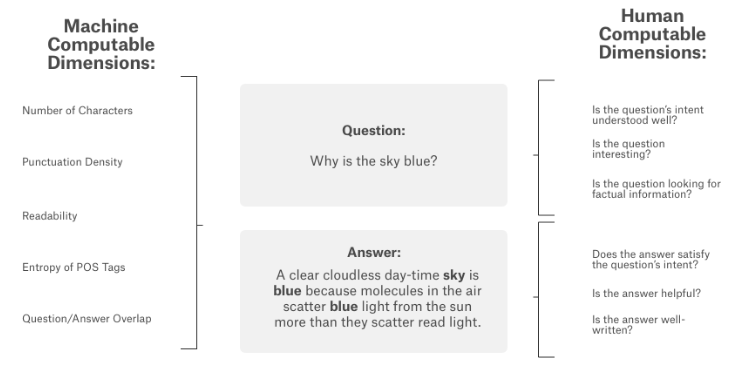

Unfortunately, it’s hard to build better subjective question-answering algorithms because of a lack of data and predictive models. That’s why the CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of these quality scoring aspects.

In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts. As such, each prompt was crafted in the most intuitive fashion so that raters could simply use their common-sense to complete the task. By lessening our dependency on complicated and opaque rating guidelines, we hope to increase the re-use value of this data set. What you see is what you get!

Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.

## Data Description
The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

Each row contains a single question and a single answer to that question, along with additional features. The training data contains rows with some duplicated questions (but with different answers). The test data does not contain any duplicated questions.

This is not a binary prediction challenge. Target labels are aggregated from multiple raters, and can have continuous values in the range [0,1]. Therefore, predictions must also be in that range.

Since this is a synchronous re-run competition, you only have access to the Public test set. For planning purposes, the re-run test set is no larger than 10,000 rows, and less than 8 Mb uncompressed.

Additional information about the labels and collection method will be provided by the competition sponsor in the forum.

## Required libraries, functions and classes:

In [ ]:
!pip3 install livelossplot --quiet
!pip3 install transformers --quiet

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import BertModel, BertTokenizer, AdamW

from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from livelossplot import PlotLosses

import datetime

from copy import deepcopy

from traceback import format_exc

In [ ]:
def init_random_seed(value=0):
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [ ]:
def divisors(n):
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i = i + 1
    return sorted(divisors)

In [ ]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [ ]:
def make_data(dataset, test=False):
    questions = [label + " " + question for label, question in zip(dataset['question_title'], dataset['question_body'])]
    answers = dataset['answer'].tolist()
    if test:
        return questions, answers
    targets = [list(row)[10:] for row in dataset.values]
    return questions, answers, targets

In [ ]:
class BertDataset(Dataset):
    def __init__(self, tokenizer, *data, max_len=None, istest=False):
        self.istest = istest
        if self.istest:
            self.questions, self.answers = data
        else:
            self.questions, self.answers, self.targets = data
        self.tokenizer = tokenizer
        self.max_len = max_len if max_len is not None else max(map(len, [train_question + train_answer for train_question, train_answer in zip(train_questions, train_answers)]))
        
    def __len__(self):
        assert len(self.questions) == len(self.answers)
        return len(self.questions)

    def __getitem__(self, item):
        question = self.questions[item]
        answer = self.answers[item]
    
        encoding = tokenizer.encode_plus(
                    answer,
                    question,
                    max_length=self.max_len,
                    add_special_tokens=True,
                    return_token_type_ids=True,
                    return_attention_mask=True,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    )
        
        if self.istest:
            return (encoding['input_ids'].squeeze(), encoding['token_type_ids'].squeeze(), encoding['attention_mask'].squeeze())
        
        target = self.targets[item]
        return (encoding['input_ids'].squeeze(), encoding['token_type_ids'].squeeze(), encoding['attention_mask'].squeeze()), torch.tensor(target)

In [ ]:
class QUEST_bert_model(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.bert_model = BertModel.from_pretrained("../input/bert-base-uncased/")
        for param in self.bert_model.parameters():
            param.requires_grad = False

    def forward(self, input_ids, token_type_ids, attention_mask):
        last_states = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, return_dict=True)['last_hidden_state']
        attention_mask = attention_mask.unsqueeze(-1)
        return ((last_states * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)).cpu()

In [ ]:
class QUEST_bert_train_model(nn.Module):
    def __init__(self, dropout=0, n_targets=30):
        super(self.__class__, self).__init__()
        self.bert_model = BertModel.from_pretrained("../input/bert-base-uncased/")
        modules = [self.bert_model.embeddings, *self.bert_model.encoder.layer[:9]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
        self.fc = nn.Linear(768, n_targets)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, return_states=False):
        input_ids, token_type_ids, attention_mask = x
        last_states = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, return_dict=True, output_hidden_states=True)['hidden_states']
        attention_mask = attention_mask.unsqueeze(-1)
        avg_states = torch.mean(torch.stack(last_states[-4:]), dim=0)
        avg_states = (avg_states * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
        if return_states is True:
            return avg_states.cpu()
        avg_states = self.dropout(avg_states)
        linear_out = self.fc(avg_states)
        logits = self.sigmoid(linear_out)
        return logits


In [ ]:
class QUEST_bert_model_with_truncation(nn.Module):
    def __init__(self, decomp_functor):
        super(self.__class__, self).__init__()
        self.bert_model = BertModel.from_pretrained("../input/bert-base-uncased/")
        self.decomp = decomp_functor
        for param in self.bert_model.parameters():
            param.requires_grad = False

    def forward(self, input_ids, token_type_ids, attention_mask):
        last_states = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, return_dict=True)['last_hidden_state']
        attention_mask = attention_mask.unsqueeze(-1)
        
        batch_out = []
        for elem in last_states * attention_mask:
            elem = elem.cpu()
            self.decomp.fit(elem)
            elem = self.decomp.transform(elem)
            batch_out.append(elem)
        return torch.tensor(batch_out).cpu()

In [ ]:
def gain_bert_aggregated_output(model, dataset, batch_size, device=None, dataloader_workers_n=5): 

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)
    
    last_states = []
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=dataloader_workers_n)
    
    model.eval()
    with torch.no_grad():
        if len(dataset[0]) == 2:
            for batch_x, _ in tqdm(dataloader):
                batch_x = copy_data_to_device(batch_x, device)
                batch_last_states = model(batch_x, return_states=True)
                last_states.extend(batch_last_states)
        else:
            for batch_x in tqdm(dataloader):
                batch_x = copy_data_to_device(batch_x, device)
                batch_last_states = model(batch_x, return_states=True)
                last_states.extend(batch_last_states)

    return last_states

In [ ]:
class PostBertDataset(Dataset):
    def __init__(self, *data, istest=False):
        self.istest = istest
        if self.istest:
            self.bert_output = data[0]
        else:
            self.bert_output, self.targets = data            
        
    def __len__(self):
        return len(self.bert_output)

    def __getitem__(self, item):
        if self.istest:
            return self.bert_output[item]
        return self.bert_output[item], torch.tensor(self.targets[item])

In [ ]:
class QUEST_model(nn.Module):
    def __init__(self, dropout=0, n_targets=30):
        super(self.__class__, self).__init__()
        self.fc = nn.Linear(768, n_targets)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, bert_aggregated_output):
        bert_aggregated_output = self.dropout(bert_aggregated_output)
        linear_out = self.fc(bert_aggregated_output)
        logits = self.sigmoid(linear_out)
        return logits

In [ ]:
class QUEST_big_model(nn.Module):
    def __init__(self, dropout=0, n_targets=30):
        super(self.__class__, self).__init__()
        self.fc1 = nn.Linear(768, 500)
        self.fc2 = nn.Linear(500, 150)
        self.fc3 = nn.Linear(150, n_targets)
        self.lrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, bert_aggregated_output):
        bert_aggregated_output = self.dropout(bert_aggregated_output)
        linear_out1 = self.fc1(bert_aggregated_output)
        linear_out1 = self.dropout(linear_out1)
        linear_out1 = self.lrelu(linear_out1)
        linear_out2 = self.fc2(linear_out1)
        linear_out2 = self.dropout(linear_out2)
        linear_out2 = self.lrelu(linear_out2)
        linear_out3 = self.fc3(linear_out2)
        logits = self.sigmoid(linear_out3)
        return logits

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, model_type, num_tokens, emb_size=32, num_units=64, num_layers=1, emb_dropout=0.0, rnn_dropout=0.0):
        super(self.__class__, self).__init__()
        if model_type == "VanillaRNN":
            self.rnn = nn.RNN(emb_size, num_units, num_layers, batch_first=True, dropout=rnn_dropout, bidirectional=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(emb_size, num_units, num_layers, batch_first=True, dropout=rnn_dropout, bidirectional=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(emb_size, num_units, num_layers, batch_first=True, dropout=rnn_dropout, bidirectional=True)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.fc = nn.Linear(2 * num_units, num_tokens)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        last_layer_hidden_states, _ = self.rnn(self.emb_dropout(x))
        last_hidden_state = last_layer_hidden_states[:,-1,:]
        linear_out = self.fc(last_hidden_state)
        logits = self.sigmoid(linear_out)
        return logits

In [ ]:
def train_eval_loop(model, train_dataset, val_dataset, criterion, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, device=None, early_stopping_patience=10, weight_decay=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, optimizer_parameters=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, 
                    show_bar=False, show_lr=False, verbose_freq=1):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        if optimizer_parameters is None:
            optimizer = optimizer_ctor(model.parameters(), lr=lr)
        else:
            optimizer = optimizer_ctor(optimizer_parameters)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    if draw_loss:
        liveplot = PlotLosses()

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()

            model.train()
            mean_train_loss = 0
            train_batches_n = 0

            for batch_x, batch_y in tqdm(train_dataloader) if show_bar else train_dataloader:
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                
                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_x, batch_y in tqdm(val_dataloader) if show_bar else val_dataloader:
                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x,)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            
            if (not draw_loss) and epoch_i % verbose_freq == 0:
                print(f"Epoch {epoch_i}")
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(train_batches_n, val_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)

            if draw_loss:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if (not draw_loss) and epoch_i % verbose_freq == 0:
                    print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()
            if (not draw_loss) and epoch_i % verbose_freq == 0:
                print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

In [ ]:
def make_prediction(model, dataset, device=None, batch_size=None, dataloader_workers_n=5):
    if batch_size is None:
        batch_size = len(dataset)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    result = []
    device = torch.device(device)
    model.to(device)
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=dataloader_workers_n)
    with torch.no_grad():
        for batch_x in tqdm(dataloader):
            batch_x = copy_data_to_device(batch_x, device)                    
            logits = model(batch_x)
            result.extend(logits.cpu().tolist())
    return result

___

## [Data](https://www.kaggle.com/c/google-quest-challenge/data) loading and preproccesing:

In [ ]:
DATA_DIR = '../input/google-quest-challenge'

In [ ]:
train_filename = f"{DATA_DIR}/train.csv"
test_filename = f"{DATA_DIR}/test.csv"
train_data, test_data = pd.read_csv(train_filename, index_col='qa_id'), pd.read_csv(test_filename, index_col=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('../input/bert-base-uncased/', do_lower_case=True, do_basic_tokenize=True)

In [ ]:
train = train_data.sample(frac=0.88, random_state=42)
val = train_data.loc[~train_data.index.isin(train.index)]

In [ ]:
train_questions, train_answers, train_targets = make_data(train)
val_questions, val_answers, val_targets = make_data(val)
test_questions, test_answers = make_data(test_data, test=True)

In [ ]:
plt.hist([len(train_question + train_answer) for train_question, train_answer in zip(train_questions, train_answers)], bins=25);

In [ ]:
plt.hist([len(val_question + val_answer) for val_question, val_answer in zip(val_questions, val_answers)], bins=25);

## Creating a dataset for bert:

In [ ]:
MAX_LEN = 500
train_bert_dataset = BertDataset(tokenizer, train_questions, train_answers, train_targets, max_len=MAX_LEN)
val_bert_dataset = BertDataset(tokenizer, val_questions, val_answers, val_targets, max_len=MAX_LEN)
test_bert_dataset = BertDataset(tokenizer, test_questions, test_answers, max_len=MAX_LEN, istest=True)

In [ ]:
print(f"divisors of train dataset size ({len(train_bert_dataset)}) are {divisors(len(train_bert_dataset))}")
print(f"divisors of val dataset size ({len(val_bert_dataset)}) are {divisors(len(val_bert_dataset))}")
print(f"divisors of test dataset size ({len(test_bert_dataset)}) are {divisors(len(test_bert_dataset))}")

batch_size_train = 10
batch_size_val = 9
batch_size_test = 7

## Creating a model:

In [ ]:
DROPOUT = 0.0
model = QUEST_bert_train_model(DROPOUT)

In [ ]:
# no_decay = ["bias", "LayerNorm.weight"]
# optimizer_parameters = [
#     {
#         "params": [p for n, p in model.named_parameters() if p.requires_grad and not any(nd in n for nd in no_decay) and "bert" in n],
#         "weight_decay": 1e-2,
#         "lr": 5e-5
#     },
#     {
#         "params": [p for n, p in model.named_parameters() if  p.requires_grad and any(nd in n for nd in no_decay) and "bert" in n], 
#         "weight_decay": 0.0,
#         "lr": 5e-5
#     },
#     {
#         "params": [p for n, p in model.named_parameters() if p.requires_grad and "bert" not in n],
#         "weight_decay": 1e-2,
#         "lr": 5e-4
#     }
#     ]

## Training:

In [ ]:
#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.75, verbose=True)

#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.75)

best_val_loss, best_model = train_eval_loop(model,
                                            train_bert_dataset,
                                            val_bert_dataset,
                                            F.binary_cross_entropy,
                                            #F.mse_loss,
                                            lr=3e-5,
                                            epoch_n=6,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            early_stopping_patience=0,
                                            weight_decay=0.01,
                                            optimizer_ctor=AdamW,
                                            optimizer_parameters=None,
                                            lr_scheduler_ctor=None,
                                            draw_loss=False,
                                            show_bar=True,
                                            dataloader_workers_n=5,
                                            verbose_freq=1)

print("best val loss:", best_val_loss)

In [ ]:
train_bert_aggregated_output = gain_bert_aggregated_output(best_model, train_bert_dataset, batch_size=batch_size_train)
val_bert_aggregated_output = gain_bert_aggregated_output(best_model, val_bert_dataset, batch_size=batch_size_val)
test_bert_aggregated_output = gain_bert_aggregated_output(best_model, test_bert_dataset, batch_size=batch_size_test)

In [ ]:
train_post_bert_dataset = PostBertDataset(train_bert_aggregated_output, train_targets)
val_post_bert_dataset = PostBertDataset(val_bert_aggregated_output, val_targets)
test_post_bert_dataset = PostBertDataset(test_bert_aggregated_output, istest=True)

In [ ]:
batch_size_train = 107
batch_size_val = 243
batch_size_test = 119

In [ ]:
DROPOUT = 0.35
model = QUEST_big_model(DROPOUT)

In [ ]:
lr_scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.75, verbose=True)

#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.75)

best_val_loss, best_final_model = train_eval_loop(model,
                                            train_post_bert_dataset,
                                            val_post_bert_dataset,
                                            #F.mse_loss,
                                            F.binary_cross_entropy,
                                            lr=2e-4,
                                            epoch_n=1001,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            early_stopping_patience=20,
                                            lr_scheduler_ctor=lr_scheduler,
                                            draw_loss=False,
                                            show_bar=False,
                                            dataloader_workers_n=5,
                                            verbose_freq=5)
print("best val loss:", best_val_loss)

## Making a prediction:

In [ ]:
test_logits = make_prediction(best_final_model, test_post_bert_dataset)

In [ ]:
test_logits = np.array(test_logits)
for i in range(30):
    test_logits[:][i] = (np.array(test_logits)[:][i] // (1/90)) * (1/90)

## Creating a submission:

In [ ]:
columns = train_data.columns.values[10:].tolist()

In [ ]:
submission = pd.DataFrame(columns=['qa_id']+columns)
submission['qa_id'] = test_data['qa_id']
submission[columns] = test_logits

In [ ]:
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)